# Clustering

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In this notebook, we will perform several types of clustering to further analyze the differences in sentiment between publications. 

First, agglomerative hierarchical clustering will be used to explore and visualize the "distance" between publications. In this form of clustering, each group starts as a separate cluster; the distance between clusters is calculated, and the two nearest clusters are put together into a larger cluster; the process repeats until all datapoints are in one big cluster. The output can be visualized as a dendrogram and is easy to udnerstand.

## Agglomerative Hierarchical Clustering

In [46]:
from sklearn.cluster import AgglomerativeClustering

First, we will use the datasets separated by articles about Democrats or about Republicans. After analyzing the publications separated by topic, we will perform the clustering again on the entire dataset.

### Articles about Republicans

In [6]:
rep_arts = pd.read_csv("~/Documents/big_data/capstone2_working_files/rep_arts.csv")
rep_arts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42689 entries, 0 to 42688
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       42689 non-null  int64  
 1   id               42689 non-null  int64  
 2   republican       42689 non-null  int64  
 3   democrat         42689 non-null  int64  
 4   prop_rep         42689 non-null  float64
 5   political        42689 non-null  int64  
 6   Unnamed: 0.1     42689 non-null  int64  
 7   title            42689 non-null  object 
 8   publication      42689 non-null  object 
 9   author           38503 non-null  object 
 10  date             40895 non-null  object 
 11  year             40895 non-null  float64
 12  month            40895 non-null  float64
 13  url              25262 non-null  object 
 14  content          42689 non-null  object 
 15  neg              42689 non-null  float64
 16  neu              42689 non-null  float64
 17  pos         

In [7]:
rep_arts.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [8]:
rep_arts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42689 entries, 0 to 42688
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               42689 non-null  int64  
 1   republican       42689 non-null  int64  
 2   democrat         42689 non-null  int64  
 3   prop_rep         42689 non-null  float64
 4   political        42689 non-null  int64  
 5   title            42689 non-null  object 
 6   publication      42689 non-null  object 
 7   author           38503 non-null  object 
 8   date             40895 non-null  object 
 9   year             40895 non-null  float64
 10  month            40895 non-null  float64
 11  url              25262 non-null  object 
 12  content          42689 non-null  object 
 13  neg              42689 non-null  float64
 14  neu              42689 non-null  float64
 15  pos              42689 non-null  float64
 16  compound         42689 non-null  float64
 17  scaled_compo

In [152]:
from sklearn.preprocessing import StandardScaler

rep_clust_info = rep_arts[['publication', 'neg', 'pos', 'neu', 'scaled_compound']]
rep_clust_median = rep_clust_info.groupby('publication').median()
X = StandardScaler().fit_transform(rep_clust_median)

agg_clust = AgglomerativeClustering(n_clusters = None, affinity='euclidean', linkage='ward', distance_threshold=0.001)
agg_clust.fit(X)

AgglomerativeClustering(distance_threshold=0.001, n_clusters=None)

In [153]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # need to create linkage matrix and then plot
    
    # cout number of samples in each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

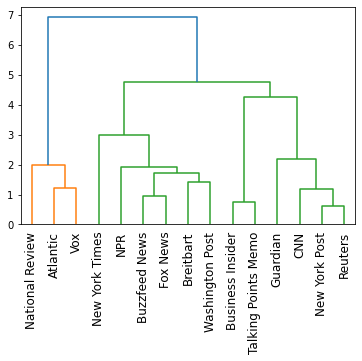

In [154]:
plot_dendrogram(agg_clust, labels=list(rep_clust_median.index))
plt.xticks(rotation=90);

By splitting the tree at about 3, we get five clear clusters. It is interesting that Breitbart and Washington post are nearest neighbors. It is also interesting that CNN is so close to the New York Post, and that the New York Post's nearest neighbor is Reuters.

In [166]:
agg_clust2 = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
agg_clust2.fit(X)

AgglomerativeClustering(n_clusters=5)

In [167]:
agg_clust2.labels_

array([1, 2, 3, 2, 0, 2, 0, 2, 1, 0, 4, 0, 3, 1, 2])

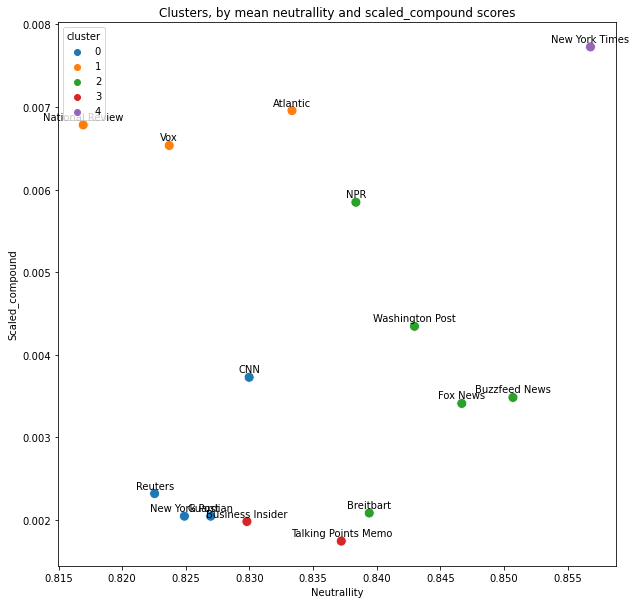

In [168]:
rep_clust_median['cluster'] = agg_clust2.labels_
rep_clust_median['cluster'] = rep_clust_median['cluster'].astype('category')
plt.figure(figsize=(10,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='cluster', data=rep_clust_median, s=100)
plt.xlabel('Neutrallity')
plt.ylabel("Scaled_compound")
plt.title("Clusters, by mean neutrallity and scaled_compound scores")
for x,y,z in zip(rep_clust_median['neu'],rep_clust_median['scaled_compound'],list(rep_clust_median.index)):

    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5),# distance from text to points (x,y)
                 ha='center');

The five clusters seem to be split as follows.

* Low neutrallity, low scaled_compound score: CNN, Reuters, New York Post, Guardian
* Middle neutrallity, very low scaled_compound score: Business Insider, Talking Points Memo
* Low neutrallity, high scaled_compound score: National Review, Vox, Atlantic
* High neutrallity, low/middle scaled_compound score: NPR, Breitbart, Washington Post, Fox News, Buzzfeed News
* High neutrallity, high scaled_compound score: The New York Times

It is interesting that the New York Times is in a category all by itself.

### Articles about Democrats

In [138]:
dem_arts = pd.read_csv("~/Documents/big_data/capstone2_working_files/dem_arts.csv")
dem_arts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24984 entries, 0 to 24983
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       24984 non-null  int64  
 1   id               24984 non-null  int64  
 2   republican       24984 non-null  int64  
 3   democrat         24984 non-null  int64  
 4   prop_rep         24984 non-null  float64
 5   political        24984 non-null  int64  
 6   Unnamed: 0.1     24984 non-null  int64  
 7   title            24983 non-null  object 
 8   publication      24984 non-null  object 
 9   author           22313 non-null  object 
 10  date             24683 non-null  object 
 11  year             24683 non-null  float64
 12  month            24683 non-null  float64
 13  url              13497 non-null  object 
 14  content          24984 non-null  object 
 15  neg              24984 non-null  float64
 16  neu              24984 non-null  float64
 17  pos         

In [139]:
dem_arts.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [141]:
dem_arts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24984 entries, 0 to 24983
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               24984 non-null  int64  
 1   republican       24984 non-null  int64  
 2   democrat         24984 non-null  int64  
 3   prop_rep         24984 non-null  float64
 4   political        24984 non-null  int64  
 5   title            24983 non-null  object 
 6   publication      24984 non-null  object 
 7   author           22313 non-null  object 
 8   date             24683 non-null  object 
 9   year             24683 non-null  float64
 10  month            24683 non-null  float64
 11  url              13497 non-null  object 
 12  content          24984 non-null  object 
 13  neg              24984 non-null  float64
 14  neu              24984 non-null  float64
 15  pos              24984 non-null  float64
 16  compound         24984 non-null  float64
 17  scaled_compo

In [171]:
dem_clust_info = dem_arts[['publication', 'neg', 'pos', 'neu', 'scaled_compound']]
dem_clust_median = dem_clust_info.groupby('publication').median()
X = StandardScaler().fit_transform(dem_clust_median)

agg_clust = AgglomerativeClustering(n_clusters = None, affinity='euclidean', linkage='ward', distance_threshold=0.001)
agg_clust.fit(X)

AgglomerativeClustering(distance_threshold=0.001, n_clusters=None)

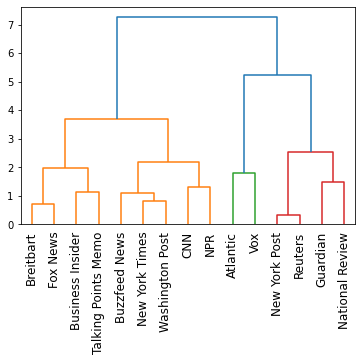

In [172]:
plot_dendrogram(agg_clust, labels=list(dem_clust_median.index))
plt.xticks(rotation=90);

This time, by cutting at 3, there are four clear groups. Fox News and Breitbart appear to be quite close together, although Breitbart is closer to Business Insider. The New York Time is quite close to the Washington Post, which is not surprising, but they are both quite close to Buzzfeed News, which was unexpected.

In [173]:
agg_clust2 = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')
agg_clust2.fit(X)

AgglomerativeClustering(n_clusters=4)

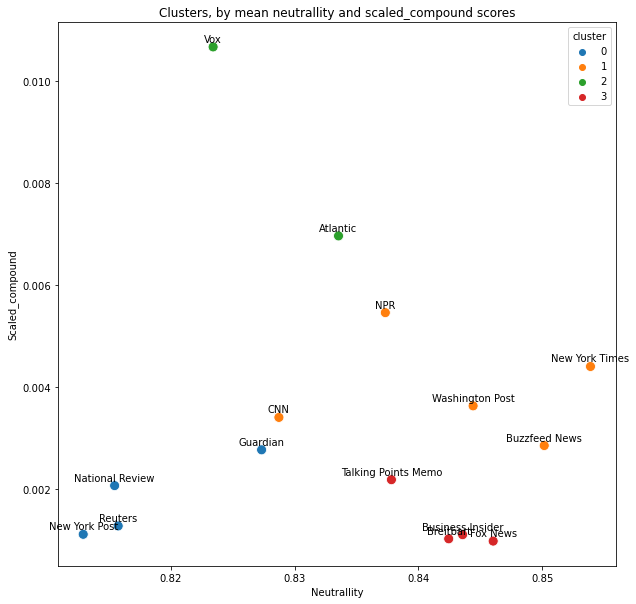

In [174]:
dem_clust_median['cluster'] = agg_clust2.labels_
dem_clust_median['cluster'] = dem_clust_median['cluster'].astype('category')
plt.figure(figsize=(10,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='cluster', data=dem_clust_median, s=100)
plt.xlabel('Neutrallity')
plt.ylabel("Scaled_compound")
plt.title("Clusters, by mean neutrallity and scaled_compound scores")
for x,y,z in zip(dem_clust_median['neu'],dem_clust_median['scaled_compound'],list(dem_clust_median.index)):

    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5),# distance from text to points (x,y)
                 ha='center');

The separation between groups is a bit more nuanced this time.

* Low neutrallity, low scaled_compound score: National Review, Reuters, New York Post, Guardian
* High neutrallity, low scaled_compound score: Talking Points Memo, Breitbart, Business Insider, Fox News
* Low/middle neutrallity, high scaled_compound score: Vox, Atlantic
* Middle/high neutrallity, middle scaled_compound score: CNN, NPR, Washington Post, Buzzfeed News, New York Times

The existence of a "middle" group, which is actually the largest group, is quite interesting.

### All articles together

In [175]:
all_arts = pd.concat([rep_arts, dem_arts])
all_arts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67673 entries, 0 to 24983
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               67673 non-null  int64  
 1   republican       67673 non-null  int64  
 2   democrat         67673 non-null  int64  
 3   prop_rep         67673 non-null  float64
 4   political        67673 non-null  int64  
 5   title            67672 non-null  object 
 6   publication      67673 non-null  object 
 7   author           60816 non-null  object 
 8   date             65578 non-null  object 
 9   year             65578 non-null  float64
 10  month            65578 non-null  float64
 11  url              38759 non-null  object 
 12  content          67673 non-null  object 
 13  neg              67673 non-null  float64
 14  neu              67673 non-null  float64
 15  pos              67673 non-null  float64
 16  compound         67673 non-null  float64
 17  scaled_compo

In [176]:
all_clust_info = all_arts[['publication', 'neg', 'pos', 'neu', 'scaled_compound']]
all_clust_median = all_clust_info.groupby('publication').median()
X = StandardScaler().fit_transform(all_clust_median)

agg_clust = AgglomerativeClustering(n_clusters = None, affinity='euclidean', linkage='ward', distance_threshold=0.001)
agg_clust.fit(X)

AgglomerativeClustering(distance_threshold=0.001, n_clusters=None)

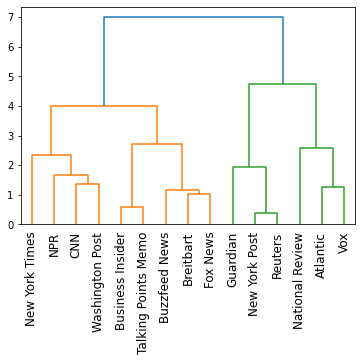

In [177]:
plot_dendrogram(agg_clust, labels=list(dem_clust_median.index))
plt.xticks(rotation=90);

By cutting at 3, we again find four distinct clusters. This time, Fox News and Breitbart are nearest neighbors, CNN and the Washington Post are nearest neighbors, Atlantic and Vox are nearest neighbors...all of which we might expect just by the general rumor of publication bias.

In [178]:
agg_clust2 = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')
agg_clust2.fit(X)

AgglomerativeClustering(n_clusters=4)

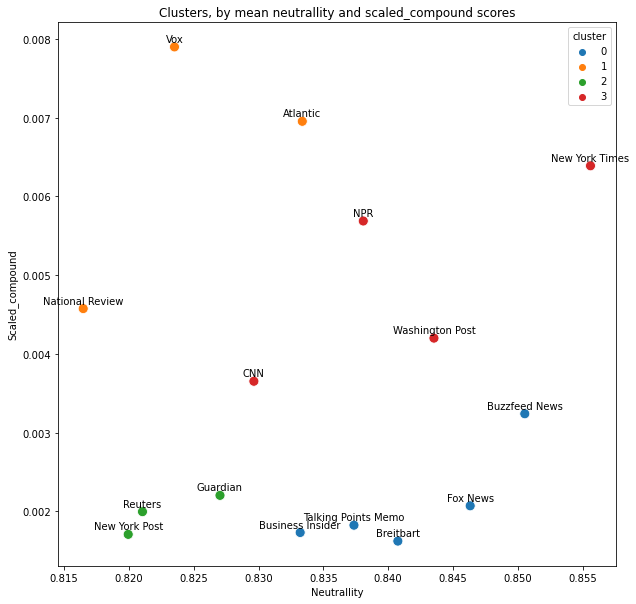

In [179]:
all_clust_median['cluster'] = agg_clust2.labels_
all_clust_median['cluster'] = all_clust_median['cluster'].astype('category')
plt.figure(figsize=(10,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='cluster', data=all_clust_median, s=100)
plt.xlabel('Neutrallity')
plt.ylabel("Scaled_compound")
plt.title("Clusters, by mean neutrallity and scaled_compound scores")
for x,y,z in zip(all_clust_median['neu'],all_clust_median['scaled_compound'],list(all_clust_median.index)):

    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5),# distance from text to points (x,y)
                 ha='center');

The publications fall into these four groups.

* Low neutrallity, low scaled_compound score: New York Post, Reuters, Guardian
* Middle/high neutrallity, low scaled_compound score: Business Insider, Talking Points Memo, Breitbart, Fox News, Buzzfeed News
* Low/middle neutrallity, middle/high scaled_compound score: National Review, Vox, Atlantic
* Middle/high neutrallity, middle/high scaled_compound score: CNN, NPR, Washington Post, New York Times

CNN is in an interesting spot; it appears to be quite near the boundaries to be either in cluster 1 or in cluster 2.

## Conclusion from Agglomerative Hierarchical Clustering

What conclusions can we draw so far?

Vox, Atlantic, and National Review, all publications known for their editorial content and deeply context-driven reporting, tend to form a group on their own. This group is the least neutral and most intensely sentimental of all clusters. However, when it comes to articles about Democrats, the positive and negative sentiment of National Review cancels out, leaving the publication in the same low-neutrallity group as the New York Post. 

The New York Post and Guardian, both publications with ties to tabloid journalism, are in the same low-neutrallity (and low sentiment intensity) group across the board, likely caused by the canceling out of positive and negative articles. What is most interesting is that Reuters falls in the same cluster.

The New York Times is especially interesting. It is in its own cluster when it comes to articles about Republicans! The New York Times is always the farthest left point, indicating high neutrallity, and is often in the same cluster as the other "mainstream" news sources: Washington Post, NPR, and CNN. 

When it comes to articles about Republicans, Fox News, Breitbart, and Buzzfeed News fall into the same category with those "mainstream" news sources; but when it comes to articles about Democrats or political reporting in general, Fox News, Breitbart, and Buzzfeed are in a separate category.

## K-Means

In [215]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial import Voronoi, voronoi_plot_2d

The next form of clustering we will use to analyze the relationships between publications is K-Means clustering. This form of clustering seeks to minize the within-cluster sum of squares:

$$\text{Within-Cluster SS} = \sum_{i=0}^n \min_{\mu_j \in C} \left( || x_i - \mu_j ||^2 \right)$$

Where $x_i$ is each point and $\mu_j$ is the center of the cluster. The single hyperparameter is the number of clusters to be formed, $k$. It is also typically recommended that PCA analysis be performed to overcome problems with the curse of dimensionality. However, we only have 4 dimensions here, so high-dimensionallity is not a problem.

The K-Means algorithm will be fit to an entire group of articles, rather than publication medians, and the clusters will then be examined for patterns.

### Articles about Republicans

In [213]:
scaler = StandardScaler()
rep_arts_numeric = rep_arts[['neg', 'pos', 'neu', 'scaled_compound']]
rep_arts_scaled = scaler.fit_transform(rep_arts_numeric)

(42689, 4)

We do not know how many clusters to make, so we will use several methods to choose. We will use the Elbow method, calculating the within-cluster sum of squares for several values of $k$, then plot the values and see where the line has an "elbow". We will also use the average silhouette method, attempting to maximize a quantitative measure of how well each object lies within its cluster. However, we will assume that the best $k$ is less than 6.

In [223]:
silhouettes = []
elbows = []
for k in range(2,6):
    kmeans = KMeans(k)
    clusters = kmeans.fit_predict(rep_arts_scaled)
    elbows.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rep_arts_scaled, clusters))

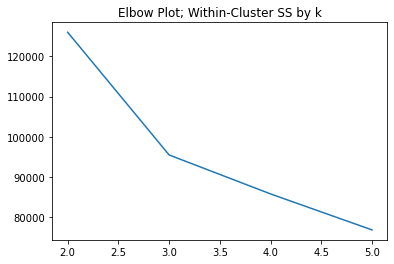

In [232]:
sns.lineplot(x=range(2,6), y=elbows)
plt.title("Elbow Plot; Within-Cluster SS by k");

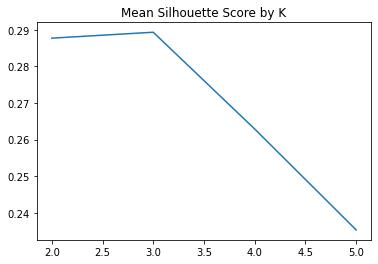

In [238]:
sns.lineplot(x=range(2,6), y=silhouettes)
plt.title('Mean Silhouette Score by K');

By both the Elbow method and Silhoeutte method, $k=3$ appears to be the best choice. Now, let's fit the best K-Means clustering model and see how the articles get grouped.

In [242]:
best_kmeans = KMeans(3)
clusters = best_kmeans.fit_predict(rep_arts_scaled)
rep_arts['k_cluster'] = clusters
rep_arts['k_cluster'] = rep_arts['k_cluster'].astype('category')

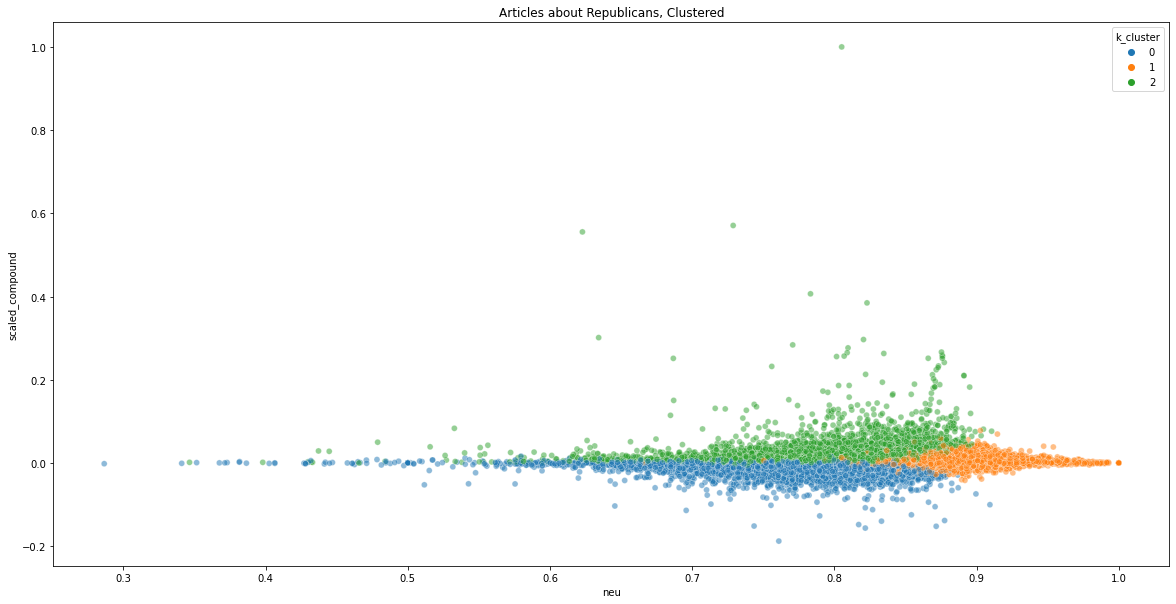

In [261]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='k_cluster', data=rep_arts, alpha=0.5)
plt.title('Articles about Republicans, Clustered');

The clusters are nicely visible in the scatterplot.

Now, we want to explore each group to see where articles from various publications are falling.

In [270]:
pub_counts = rep_arts.groupby('publication')['id'].count()
clust_counts = rep_arts.groupby('k_cluster')['id'].count()

I want the percentage of each cluster that is made up of articles from each publication, compared to the percentage of the total population that is made up of articles from that publication; so that we can see if any publication is disproportionately represented in any cluster.

In [284]:
total_pct = pub_counts / rep_arts.shape[0]
pub_clust_counts = rep_arts.groupby(['k_cluster', 'publication'])['id'].count()
pub_clust_counts

k_cluster  publication        
0          Atlantic                576
           Breitbart              2017
           Business Insider        409
           Buzzfeed News           270
           CNN                     830
           Fox News                261
           Guardian                817
           NPR                     447
           National Review         780
           New York Post           561
           New York Times          399
           Reuters                1415
           Talking Points Memo     622
           Vox                     595
           Washington Post        1255
1          Atlantic                844
           Breitbart              3683
           Business Insider        985
           Buzzfeed News           593
           CNN                    1295
           Fox News                617
           Guardian                774
           NPR                    1143
           National Review         487
           New York Post         

In [291]:
clust0 = pd.DataFrame({'count':pub_clust_counts[0], 'total_pct':total_pct})
clust0['cluster_pct'] = clust0['count'] / clust0['count'].sum()
clust0['diff'] = clust0['cluster_pct'] - clust0['total_pct']
clust0

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,576,0.055190,0.051182,-0.004008
Breitbart,2017,0.189346,0.179225,-0.010121
Business Insider,409,0.040596,0.036343,-0.004253
Buzzfeed News,270,0.027572,0.023991,-0.003580
CNN,830,0.070791,0.073752,0.002960
Fox News,261,0.027009,0.023192,-0.003818
Guardian,817,0.053386,0.072596,0.019210
NPR,447,0.053995,0.039719,-0.014276
National Review,780,0.058774,0.069309,0.010535


There are a few publications that are disproportionately represented in Cluster 0 (low/middle neutrallity, negative scaled_compound score). We take a difference of more than 0.01 to be 'disproportionate'.

* OVER-represented: 
    * Guardian
    * National Review
    * Reuters
    * Vox
* UNDER-represented:
    * NPR
    * New York Times
    * Talking Points Memo
    * Breitbart
    
Those that are over-represented have more articles about Republicans that are less neutral/mostly negative than the general population; those that are under-represented have more articles about Republicans that are more neutral/mostly positive than the general population.

In [292]:
clust1 = pd.DataFrame({'count':pub_clust_counts[1], 'total_pct':total_pct})
clust1['cluster_pct'] = clust1['count'] / clust1['count'].sum()
clust1['diff'] = clust1['cluster_pct'] - clust1['total_pct']
clust1

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,844,0.055190,0.045425,-0.009765
Breitbart,3683,0.189346,0.198224,0.008878
Business Insider,985,0.040596,0.053014,0.012418
Buzzfeed News,593,0.027572,0.031916,0.004345
CNN,1295,0.070791,0.069699,-0.001092
Fox News,617,0.027009,0.033208,0.006198
Guardian,774,0.053386,0.041658,-0.011728
NPR,1143,0.053995,0.061518,0.007523
National Review,487,0.058774,0.026211,-0.032563


Cluster 1 contains the articles with the highest neutrallity score, and has scaled_mean scores both above and below zero but always quite close to zero. The following articles are disporportionately represented in Cluster 1. Again, the cutoff for disporportionallity is a difference of 0.01 between total percentage and cluster percentage.

* OVER-represented:
    * Business Insider
    * New York Times
    * Talking Points Memo
* UNDER-represented:
    * Guardian
    * National Review
    * Vox

Those that are over-represented have more articles about Republicans that are more neutral than the general population; those that are under-represented have fewer articles about Republicans that are more neutral than the general population.

In [293]:
clust2 = pd.DataFrame({'count':pub_clust_counts[2], 'total_pct':total_pct})
clust2['cluster_pct'] = clust2['count'] / clust2['count'].sum()
clust2['diff'] = clust2['cluster_pct'] - clust2['total_pct']
clust2

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,936,0.055190,0.072812,0.017622
Breitbart,2383,0.189346,0.185375,-0.003971
Business Insider,339,0.040596,0.026371,-0.014225
Buzzfeed News,314,0.027572,0.024426,-0.003145
CNN,897,0.070791,0.069778,-0.001013
Fox News,275,0.027009,0.021392,-0.005617
Guardian,688,0.053386,0.053520,0.000134
NPR,715,0.053995,0.055620,0.001625
National Review,1242,0.058774,0.096616,0.037842


Articles in Cluster 2 have low/mid neutrallity and positive compound sentiment scores. The publications that are disproportionately represented in Cluster 2 are:

* OVER-represented:
    * Atlantic
    * National Review
    * Vox
* UNDER-represented:
    * Business Insider
    * Reuters
    * Talking Points Memo

Those that are over-represented here have more articles about Republicans that are less neutral/more positive than the general population; those that are under-represented have fewer articles about Republicans that are less neutral/more positive than the general population.

It is interesting that none of the "usual" news publications are disproportionately represented in this cluster. It is also interesting that the New York Times is disproportionately represented in Clusters 0 and 1 (under and over, respectively), indicating that is features both less negative and more neutral reporting in these articles than the general population.

### Articles about Democrats

Analysis of articles about Democrats will follow exactly the same procedure as the analysis of articles about Republicans.

In [296]:
scaler = StandardScaler()
dem_arts_numeric = dem_arts[['neg', 'pos', 'neu', 'scaled_compound']]
dem_arts_scaled = scaler.fit_transform(dem_arts_numeric)

In [297]:
silhouettes = []
elbows = []
for k in range(2,6):
    kmeans = KMeans(k)
    clusters = kmeans.fit_predict(dem_arts_scaled)
    elbows.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(dem_arts_scaled, clusters))

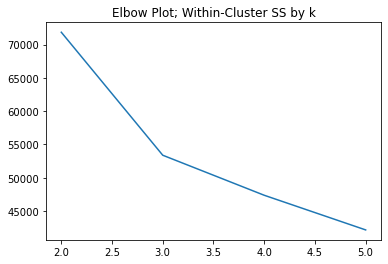

In [298]:
sns.lineplot(x=range(2,6), y=elbows)
plt.title("Elbow Plot; Within-Cluster SS by k");

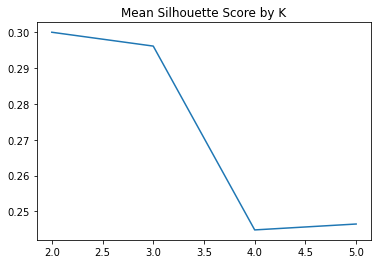

In [299]:
sns.lineplot(x=range(2,6), y=silhouettes)
plt.title('Mean Silhouette Score by K');

As with the articles about Republicans, the best choice for $k$ appears to be 3.

In [300]:
best_kmeans = KMeans(3)
clusters = best_kmeans.fit_predict(dem_arts_scaled)
dem_arts['k_cluster'] = clusters
dem_arts['k_cluster'] = dem_arts['k_cluster'].astype('category')

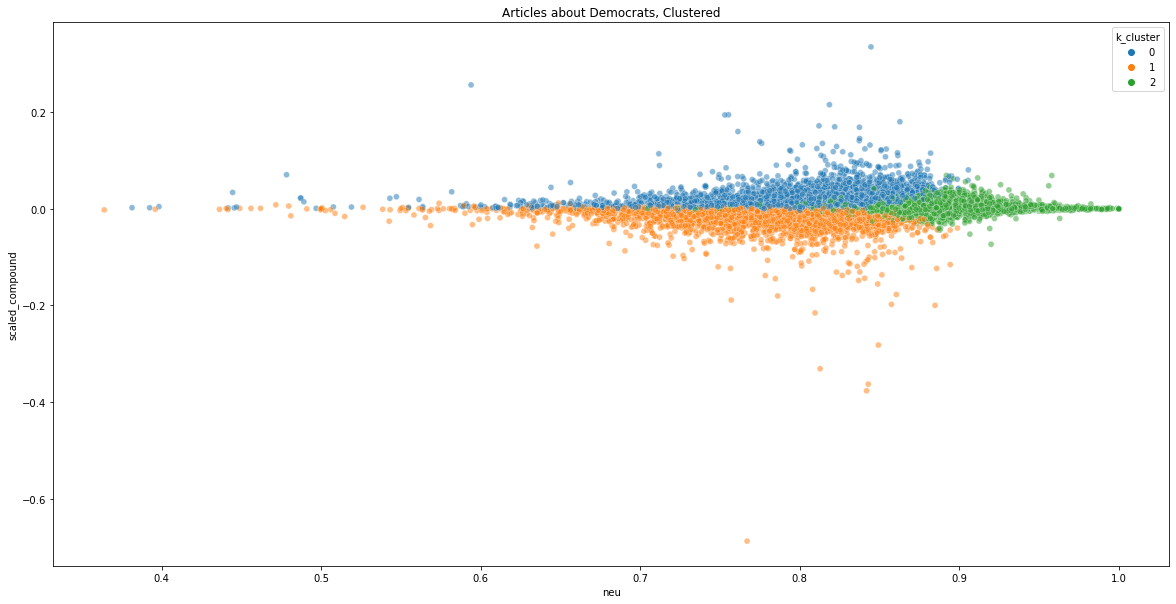

In [302]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='k_cluster', data=dem_arts, alpha=0.5)
plt.title('Articles about Democrats, Clustered');

The clusters are ***very*** similar to the ones found in the articles about Republicans. The main difference in the plots is that articles about Democrats have low outliers on the scaled_compound axis, while articles about Republicans have high outliers.

In [303]:
pub_counts = dem_arts.groupby('publication')['id'].count()
clust_counts = dem_arts.groupby('k_cluster')['id'].count()

In [304]:
total_pct = pub_counts / dem_arts.shape[0]
pub_clust_counts = dem_arts.groupby(['k_cluster', 'publication'])['id'].count()
pub_clust_counts

k_cluster  publication        
0          Atlantic                579
           Breitbart              1473
           Business Insider        171
           Buzzfeed News           184
           CNN                     667
           Fox News                258
           Guardian                372
           NPR                     522
           National Review         827
           New York Post           426
           New York Times          422
           Reuters                 366
           Talking Points Memo     265
           Vox                     546
           Washington Post         751
1          Atlantic                288
           Breitbart              1558
           Business Insider        158
           Buzzfeed News           155
           CNN                     499
           Fox News                297
           Guardian                311
           NPR                     353
           National Review         773
           New York Post         

In [305]:
clust0 = pd.DataFrame({'count':pub_clust_counts[0], 'total_pct':total_pct})
clust0['cluster_pct'] = clust0['count'] / clust0['count'].sum()
clust0['diff'] = clust0['cluster_pct'] - clust0['total_pct']
clust0

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,579,0.051393,0.073956,0.022563
Breitbart,1473,0.244997,0.188147,-0.056850
Business Insider,171,0.029379,0.021842,-0.007537
Buzzfeed News,184,0.027217,0.023502,-0.003715
CNN,667,0.076169,0.085196,0.009027
Fox News,258,0.050993,0.032954,-0.018038
Guardian,372,0.039906,0.047516,0.007610
NPR,522,0.062200,0.066675,0.004475
National Review,827,0.083013,0.105633,0.022620


As with the articles about Republicans, we will consider a difference more than 0.01 to indicate disproportionate representation. In this case, Cluster 0 contains articles that have low/middle neutrallity and positive compound sentiment.

* OVER-represented:
    * Atlantic
    * National Review
    * Vox
* UNDER-represented:
    * Breitbart
    * Fox News

It is definitely worth noting that Breitbart is under-represented by 0.05; by far the largest disproportionate representation of any publication or cluster so far. 

Those that are over-represented here have more articles about Democrats that are less neutral and more positive than the general population; those that are under-represented have fewer articles about Democrats that are less neutral or more positive than the general population.

In [306]:
clust1 = pd.DataFrame({'count':pub_clust_counts[1], 'total_pct':total_pct})
clust1['cluster_pct'] = clust1['count'] / clust1['count'].sum()
clust1['diff'] = clust1['cluster_pct'] - clust1['total_pct']
clust1

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,288,0.051393,0.043976,-0.007417
Breitbart,1558,0.244997,0.237899,-0.007098
Business Insider,158,0.029379,0.024126,-0.005253
Buzzfeed News,155,0.027217,0.023668,-0.003550
CNN,499,0.076169,0.076195,0.000026
Fox News,297,0.050993,0.045350,-0.005642
Guardian,311,0.039906,0.047488,0.007583
NPR,353,0.062200,0.053901,-0.008298
National Review,773,0.083013,0.118033,0.035020


In articles about Democrats, Cluster 1 contains articles that have low/middle neutrallity and negative compound scores. There are a few disproportionately represented publications here, too.

* OVER-represented:
    * National Review
    * New York Post
    * Reuters
* UNDER-represented:
    * Talking Points Memo

Those that are over-represented have more articles about Democrats that are less neutral and more negative than the general population; those that are under-represented have fewer articles about Democrats that are less neutral and more negative than the general population.

It is interesting that National Review is over-represented in both the positive and negative categories. Thus, we can conclude that they tend to be pretty sentimental in articles about Democrats, whether positive or negative.

In [307]:
clust2 = pd.DataFrame({'count':pub_clust_counts[2], 'total_pct':total_pct})
clust2['cluster_pct'] = clust2['count'] / clust2['count'].sum()
clust2['diff'] = clust2['cluster_pct'] - clust2['total_pct']
clust2

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,417,0.051393,0.039317,-0.012076
Breitbart,3090,0.244997,0.291345,0.046348
Business Insider,405,0.029379,0.038186,0.008807
Buzzfeed News,341,0.027217,0.032152,0.004934
CNN,737,0.076169,0.069489,-0.006680
Fox News,719,0.050993,0.067792,0.016799
Guardian,314,0.039906,0.029606,-0.010300
NPR,679,0.062200,0.064020,0.001821
National Review,474,0.083013,0.044692,-0.038321


Cluster 3 contains articles that have high neutrallity and compound scores near zero. The compound scores can be either positive or negative, but they do not have the strongly sentimental outliers that the other clusters have.

* OVER-represented:
    * Breitbart
    * Fox News
    * Talking Points Memo
* UNDER-represented:
    * Atlantic
    * Guardian
    * National Review
    * Vox
    
Again, Breitbart has a sizable difference (0.04).

Those that are over-represented here have more articles about Democrats with high neutrallity scores than the general population; those that are under-represented have more articles about Democrats that have low neutrallity scores. This cluster does not tell us whether the compound scores (overall sentiment) of those articles are positive or negative.

The best thing to take away from this portion of the clustering is that the most "mainstream" news sources - New York Times, Washington Post, NPR, and CNN - are neither over-represented nor under-represented in any of the clusters of articles about Democrats. This implies that they have articles evenly distributed between the three groups; a mix of neutrallities and a mix of positive and negative overall sentiments.

### All articles together

Since we have gone through the analysis twice now, there will be little discussion of the process in this section.

In [308]:
scaler = StandardScaler()
all_arts_numeric = all_arts[['neg', 'pos', 'neu', 'scaled_compound']]
all_arts_scaled = scaler.fit_transform(all_arts_numeric)

In [313]:
silhouettes = []
elbows = []
for k in range(2,10):
    kmeans = KMeans(k)
    clusters = kmeans.fit_predict(all_arts_scaled)
    elbows.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(all_arts_scaled, clusters))

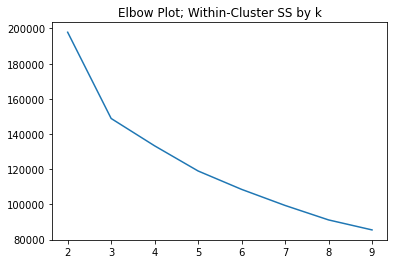

In [314]:
sns.lineplot(x=range(2,10), y=elbows)
plt.title("Elbow Plot; Within-Cluster SS by k");

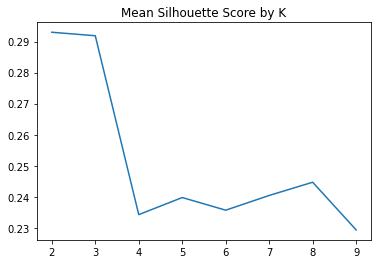

In [316]:
sns.lineplot(x=range(2,10), y=silhouettes)
plt.title('Mean Silhouette Score by K');

It still looks like 3 is the best number of clusters; there is an elbow at 3, and 3 has a higher silhouette score than any higher number of clusters.

In [353]:
best_kmeans = KMeans(3)
clusters = best_kmeans.fit_predict(all_arts_scaled)
all_arts['k_cluster'] = clusters
all_arts['k_cluster'] = all_arts['k_cluster'].astype('category')

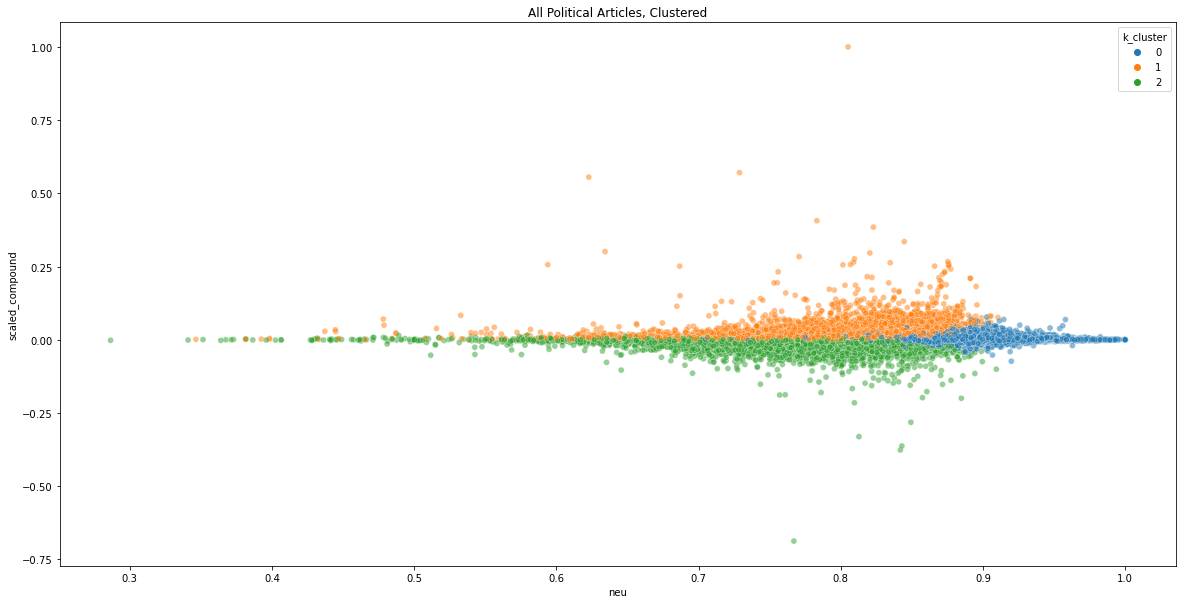

In [354]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='k_cluster', data=all_arts, alpha=0.5)
plt.title('All Political Articles, Clustered');

The *meaning* of the clusters has not changed; but now, in addition to looking for publications that are disproportionately represented in each cluster, we will also look for disproportionate numbers of articles either about Democrats or Republicans.

In [323]:
pub_counts = all_arts.groupby('publication')['id'].count()
clust_counts = all_arts.groupby('k_cluster')['id'].count()

In [324]:
total_pct = pub_counts / all_arts.shape[0]
pub_clust_counts = all_arts.groupby(['k_cluster', 'publication'])['id'].count()
pub_clust_counts

k_cluster  publication        
0          Atlantic               1530
           Breitbart              3859
           Business Insider        521
           Buzzfeed News           493
           CNN                    1568
           Fox News                525
           Guardian               1076
           NPR                    1238
           National Review        2066
           New York Post           979
           New York Times         1059
           Reuters                1458
           Talking Points Memo     922
           Vox                    1366
           Washington Post        2152
1          Atlantic                852
           Breitbart              3603
           Business Insider        565
           Buzzfeed News           430
           CNN                    1323
           Fox News                564
           Guardian               1121
           NPR                     798
           National Review        1564
           New York Post         

In [325]:
clust0 = pd.DataFrame({'count':pub_clust_counts[0], 'total_pct':total_pct})
clust0['cluster_pct'] = clust0['count'] / clust0['count'].sum()
clust0['diff'] = clust0['cluster_pct'] - clust0['total_pct']
clust0

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,1530,0.053788,0.073515,0.019727
Breitbart,3859,0.209892,0.185422,-0.024470
Business Insider,521,0.036455,0.025034,-0.011421
Buzzfeed News,493,0.027441,0.023688,-0.003753
CNN,1568,0.072776,0.075341,0.002565
Fox News,525,0.035864,0.025226,-0.010638
Guardian,1076,0.048409,0.051701,0.003292
NPR,1238,0.057024,0.059485,0.002461
National Review,2066,0.067723,0.099270,0.031547


Cluster 0, in this case, contains articles that have low/middle neutrallity and positive compound sentiment scores. 

* OVER-represented:
    * Atlantic
    * National Review
    * Vox
* UNDER-represented:
    * Breitbart
    * Business Insider
    * Fox News
    * Reuters
    * Talking Points Memo

Those are over-represented have more political articles that are less neutral and more positive than the general population; those that are under-represented have fewer political articles that are less neutral and more positive than the general population.

In [326]:
clust1 = pd.DataFrame({'count':pub_clust_counts[1], 'total_pct':total_pct})
clust1['cluster_pct'] = clust1['count'] / clust1['count'].sum()
clust1['diff'] = clust1['cluster_pct'] - clust1['total_pct']
clust1

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,852,0.053788,0.047943,-0.005845
Breitbart,3603,0.209892,0.202746,-0.007146
Business Insider,565,0.036455,0.031793,-0.004661
Buzzfeed News,430,0.027441,0.024197,-0.003244
CNN,1323,0.072776,0.074447,0.001671
Fox News,564,0.035864,0.031737,-0.004127
Guardian,1121,0.048409,0.063080,0.014671
NPR,798,0.057024,0.044905,-0.012120
National Review,1564,0.067723,0.088009,0.020286


In all articles, Cluster 1 refers to those that have low/middle neutrallity and negative compound sentiment scores.

* OVER-represented:
    * Guardian
    * National review
    * Reuters
* UNDER-represented:
    * NPR
    * New York Times
    * Talking Points Memo
    
Those that are over-represented have more articles that are less neutral and more negative than the general population; those that are under-represented have fewer articles that are less neutral and more negative than the general population.

It is interesting that the New York Times is under-represented here. It has often been an outlier, throughout this analysis.

In [327]:
clust2 = pd.DataFrame({'count':pub_clust_counts[2], 'total_pct':total_pct})
clust2['cluster_pct'] = clust2['count'] / clust2['count'].sum()
clust2['diff'] = clust2['cluster_pct'] - clust2['total_pct']
clust2

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,1258,0.053788,0.043245,-0.010543
Breitbart,6742,0.209892,0.231763,0.021872
Business Insider,1381,0.036455,0.047473,0.011019
Buzzfeed News,934,0.027441,0.032107,0.004666
CNN,2034,0.072776,0.069921,-0.002856
Fox News,1338,0.035864,0.045995,0.010132
Guardian,1079,0.048409,0.037092,-0.011317
NPR,1823,0.057024,0.062668,0.005643
National Review,953,0.067723,0.032760,-0.034962


Cluster 2 refers to those articles with higher neutrallity scores and either positive or negative overall sentiment near zero.

* OVER-represented:
    * Breitbart
    * Business Insider
    * Fox News
    * New York Times
    * Talking Points Memo
* UNDER-represented:
    * Atlantic
    * Guardian
    * National Review
    * Vox
    
Those that are over-represented in this cluster have more political articles with high neutrallity scores than the general population; those that are under-represented have fewer political articles with high neutrallity scores than the general population. 

It is interesting that the New York Times appears over-represented in this cluster; it has the highest median neutrallity score of all publications in this study. It is also interesting that neither CNN nor the Washington Post appear as either over or under represented in any cluster. The two publications must have a well-distributed mix of neutrallity and compound scores.

Now, we want to examine each cluster for disproportionate representation of articles either about Democrats or Republicans.

In [335]:
dem_arts['party'] = 'dem'
rep_arts['party'] = 'rep'
all_arts = pd.concat([rep_arts, dem_arts])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67673 entries, 0 to 24983
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               67673 non-null  int64   
 1   republican       67673 non-null  int64   
 2   democrat         67673 non-null  int64   
 3   prop_rep         67673 non-null  float64 
 4   political        67673 non-null  int64   
 5   title            67672 non-null  object  
 6   publication      67673 non-null  object  
 7   author           60816 non-null  object  
 8   date             65578 non-null  object  
 9   year             65578 non-null  float64 
 10  month            65578 non-null  float64 
 11  url              38759 non-null  object  
 12  content          67673 non-null  object  
 13  neg              67673 non-null  float64 
 14  neu              67673 non-null  float64 
 15  pos              67673 non-null  float64 
 16  compound         67673 non-null  float64

In [337]:
party_counts = all_arts.groupby('party')['id'].count()
total_pct = party_counts / all_arts.shape[0]
party_clust_counts = all_arts.groupby(['k_cluster', 'party'])['id'].count()
party_clust_counts

k_cluster  party
0          dem       7829
           rep      11254
1          dem       6549
           rep      18580
2          dem      10606
           rep      12855
Name: id, dtype: int64

In [346]:
clust0 = pd.DataFrame({'count':party_clust_counts[0], 'total_pct':total_pct})
clust0['cluster_pct'] = clust0['count'] / clust0['count'].sum()
clust0['diff'] = clust0['cluster_pct'] - clust0['total_pct']
clust0

,count,total_pct,cluster_pct,diff
party,,,,
dem,7829,0.369187,0.41026,0.041073
rep,11254,0.630813,0.58974,-0.041073


In Cluster 0, where articles have low/middle neutrallity and positive compound scores, articles about Democrats are over-represented while articles about Republicans are under-represented.

In [347]:
clust1 = pd.DataFrame({'count':party_clust_counts[1], 'total_pct':total_pct})
clust1['cluster_pct'] = clust1['count'] / clust1['count'].sum()
clust1['diff'] = clust1['cluster_pct'] - clust1['total_pct']
clust1

,count,total_pct,cluster_pct,diff
party,,,,
dem,6549,0.369187,0.260615,-0.108572
rep,18580,0.630813,0.739385,0.108572


In Cluster 1, where articles have low/middle neutrallity and negative compound scores, articles about Democrats are under-represented while articles about Republicans are over-represented.

In [348]:
clust2 = pd.DataFrame({'count':party_clust_counts[2], 'total_pct':total_pct})
clust2['cluster_pct'] = clust2['count'] / clust2['count'].sum()
clust2['diff'] = clust2['cluster_pct'] - clust2['total_pct']
clust2

,count,total_pct,cluster_pct,diff
party,,,,
dem,10606,0.369187,0.452069,0.082882
rep,12855,0.630813,0.547931,-0.082882


In Cluster 2, where articles have high neutrallity scores, articles about Democrats are over-represented while articles about Republicans are under-represented.

## Conclusions from K-Means

From the K-Means clustering section, we can draw a few conclusions.

First, in the section right above this one, we saw that articles about Republicans are disproportionately represented by articles with the most negative sentiment. However, we saw from the ANOVAs and linear models in the last notebook that overall news sentiment toward Republicans is quite positive. On the other hands, Democrats are most disproportionately over-represented in the articles with high neutrallity scores.

Second, most of the "mainstream media" publications (Washington Post, CNN, NPR), are the least disproportionately represented publications; this implies that these outlets have a proportional mix of neutrallities and compound sentiment scores. The New York Times is the outlier "mainstream" publication; it is over-represented in positive articles about Republicans, under-represented in negative articles about Republicans, and over-represented in highly neutral political articles in general.

Third, National Review is over-represented in both positive and negative articles in all topic groups, while being under-represented in highly neutral articles in all topic groups. Atlantic and Vox are also often either over or under represented in low/middle neutrallity clusters. These are the publications most known for their editorial-style, context-heavy reporting.

Fourth, Breitbart is under-represented in negative articles about Republicans, while being over-represented in negative articles about Democrats. Fox News is also over-represented in negative articles about Democrats. Both of these publications are under-represented in positive articles in general. This implies that Breitbart and Fox News both tend to have more negative coverage than positive coverage. On the other hand, Atlantic, Vox, and National Review are all regularly over-represented in clusters with positive compound scores. 

## DBSCAN

In [350]:
from sklearn.cluster import DBSCAN

DBSCAN is a well-known and often-used clustering algorithm. It groups data-points together based on density; it finds the *core* points, those with many neighbors with $\epsilon$ distance, then other points are either places into a group with the nearest core point or excluded from all groups and branded an outlier.

The hyperparemters for the sci-kit learn implementation of DBSCAN are **eps**, the maximum distance a point can be from the cluster core, and **min_samples** , the minimum number of points allowed to form a cluster. There are other parameters that can be set by the user, but we will only use the two mandatory hyperparameters for the algorithm.

We want to set **eps**, the most important hyperparameter, and **min_samples** such that the algorithm finds a reasonable number of interpretable clusters. Only the final values appear below.

### Articles about Republicans

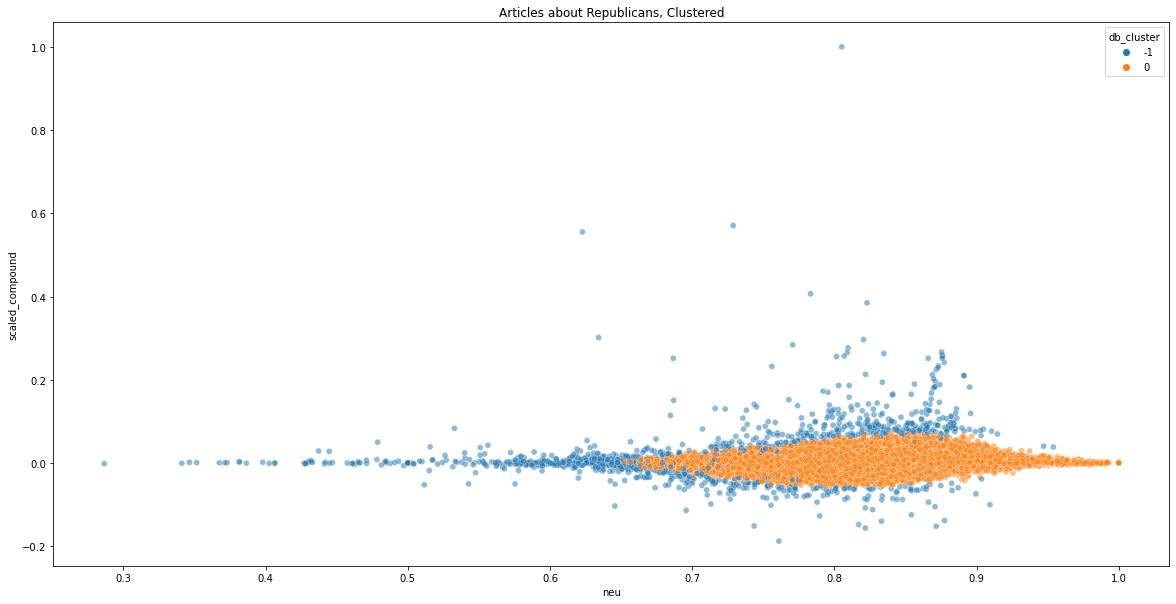

In [382]:
dbscan_rep = DBSCAN(eps=0.75, min_samples=100)
db_rep_clusters = dbscan_rep.fit_predict(rep_arts_scaled)
rep_arts['db_cluster'] = db_rep_clusters
rep_arts['db_cluster'] = rep_arts['db_cluster'].astype('category')
plt.figure(figsize=(20,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='db_cluster', data=rep_arts, alpha=0.5)
plt.title('Articles about Republicans, Clustered');

The DBSCAN algorithm finds 1 cluster (the -1 cluster is noise). With **eps** set lower or **min_samples** set higher, the algorithm finds a large number of clusters with very few data points, which is not helpful. 

In [383]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(rep_arts.groupby(['db_cluster', 'publication'])['id'].count())

db_cluster  publication        
-1          Atlantic                145
            Breitbart               380
            Business Insider         98
            Buzzfeed News            41
            CNN                      74
            Fox News                 13
            Guardian                 49
            NPR                      92
            National Review          99
            New York Post            66
            New York Times           33
            Reuters                  65
            Talking Points Memo     207
            Vox                     106
            Washington Post         122
 0          Atlantic               2211
            Breitbart              7703
            Business Insider       1635
            Buzzfeed News          1136
            CNN                    2948
            Fox News               1140
            Guardian               2230
            NPR                    2213
            National Review        2410
        

In [417]:
total_pct = rep_arts.groupby('publication')['id'].count() / rep_arts.shape[0]
clust_neg1 = pd.DataFrame({'count':rep_arts.groupby(['db_cluster', 'publication'])['id'].count()[-1], 'total_pct':total_pct})
clust_neg1['cluster_pct'] = clust_neg1['count'] / clust_neg1['count'].sum()
clust_neg1['diff'] = clust_neg1['cluster_pct'] - clust_neg1['total_pct']
clust_neg1

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,145,0.055190,0.091195,0.036005
Breitbart,380,0.189346,0.238994,0.049648
Business Insider,98,0.040596,0.061635,0.021039
Buzzfeed News,41,0.027572,0.025786,-0.001785
CNN,74,0.070791,0.046541,-0.024250
Fox News,13,0.027009,0.008176,-0.018833
Guardian,49,0.053386,0.030818,-0.022569
NPR,92,0.053995,0.057862,0.003866
National Review,99,0.058774,0.062264,0.003490


This is the noise cluster; publications that are over-represented here have more sentimental outliers than expected; publications that are under-represented here have fewer sentimental outliers than expected.

* OVER-represented:
    * Atlantic
    * Breitbart
    * Business Insider
    * Talking Points Memo
    * Vox
* UNDER-represented:
    * CNN
    * Fox News
    * Guardian
    * New York Times
    * Reuters
    * Washington Post

It is interesting that Breitbart is over-represented in the noise cluster; since the publication is a large portion of articles, it takes a large role in defining the norm.

In [418]:
clust_0 = pd.DataFrame({'count':rep_arts.groupby(['db_cluster', 'publication'])['id'].count()[0], 'total_pct':total_pct})
clust_0['cluster_pct'] = clust_0['count'] / clust_0['count'].sum()
clust_0['diff'] = clust_0['cluster_pct'] - clust_0['total_pct']
clust_0

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,2211,0.055190,0.053797,-0.001393
Breitbart,7703,0.189346,0.187425,-0.001921
Business Insider,1635,0.040596,0.039782,-0.000814
Buzzfeed News,1136,0.027572,0.027641,0.000069
CNN,2948,0.070791,0.071729,0.000938
Fox News,1140,0.027009,0.027738,0.000729
Guardian,2230,0.053386,0.054259,0.000873
NPR,2213,0.053995,0.053846,-0.000150
National Review,2410,0.058774,0.058639,-0.000135


This is the "normal" cluster; since there is only one cluster, the cluster defines normalcy and the rest of the points are noise. Publications that are over-represented in this cluster have more articles about Republicans that are in the normal range for sentiment intensity; publications that are under-represented have more articles that are abnormally sentimental than the norm.

There are no publications that are disproportionately represented in the "normal" cluster.

### Articles about Democrats

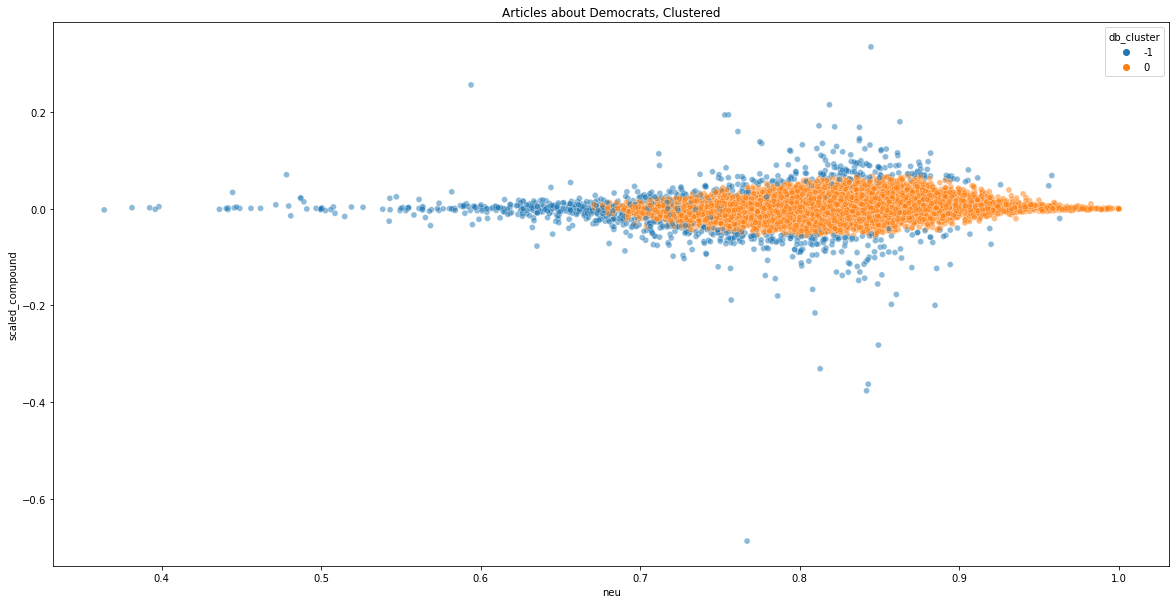

In [403]:
dbscan_dem = DBSCAN(eps=0.75, min_samples=100)
db_dem_clusters = dbscan_dem.fit_predict(dem_arts_scaled)
dem_arts['db_cluster'] = db_dem_clusters
dem_arts['db_cluster'] = dem_arts['db_cluster'].astype('category')
plt.figure(figsize=(20,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='db_cluster', data=dem_arts, alpha=0.5)
plt.title('Articles about Democrats, Clustered');

The same hyperparameters appear to work well for the articles about Democrats. There are visibly fewer points in the outlier cluster for this dataset.

In [404]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dem_arts.groupby(['db_cluster', 'publication'])['id'].count())

db_cluster  publication        
-1          Atlantic                 81
            Breitbart               272
            Business Insider         56
            Buzzfeed News            33
            CNN                     102
            Fox News                 31
            Guardian                 38
            NPR                      91
            National Review         105
            New York Post            81
            New York Times           36
            Reuters                  34
            Talking Points Memo      84
            Vox                      89
            Washington Post         115
 0          Atlantic               1203
            Breitbart              5849
            Business Insider        678
            Buzzfeed News           647
            CNN                    1801
            Fox News               1243
            Guardian                959
            NPR                    1463
            National Review        1969
        

In [420]:
total_pct = dem_arts.groupby('publication')['id'].count() / dem_arts.shape[0]
clust_neg1 = pd.DataFrame({'count':dem_arts.groupby(['db_cluster', 'publication'])['id'].count()[-1], 'total_pct':total_pct})
clust_neg1['cluster_pct'] = clust_neg1['count'] / clust_neg1['count'].sum()
clust_neg1['diff'] = clust_neg1['cluster_pct'] - clust_neg1['total_pct']
clust_neg1

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,81,0.051393,0.064904,0.013511
Breitbart,272,0.244997,0.217949,-0.027048
Business Insider,56,0.029379,0.044872,0.015493
Buzzfeed News,33,0.027217,0.026442,-0.000775
CNN,102,0.076169,0.081731,0.005562
Fox News,31,0.050993,0.024840,-0.026153
Guardian,38,0.039906,0.030449,-0.009457
NPR,91,0.062200,0.072917,0.010717
National Review,105,0.083013,0.084135,0.001121


This is the outlier cluster. Publications that are over-represented here have more articles about Democrats that are outside of the "mainstream" sentiment for those articles; publications that are under-represented have fewer articles outside the realm of "normal" sentiment intensity.

* OVER-represented:
    * Atlantic
    * Business Insider
    * NPR
    * Talking Points Memo
    * Vox
* UNDER-represented:
    * Breitbart
    * Fox News
    * New York Times
    * Reuters

In [421]:
clust_0 = pd.DataFrame({'count':dem_arts.groupby(['db_cluster', 'publication'])['id'].count()[0], 'total_pct':total_pct})
clust_0['cluster_pct'] = clust_0['count'] / clust_0['count'].sum()
clust_0['diff'] = clust_0['cluster_pct'] - clust_0['total_pct']
clust_0

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,1203,0.051393,0.050683,-0.000710
Breitbart,5849,0.244997,0.246419,0.001422
Business Insider,678,0.029379,0.028564,-0.000815
Buzzfeed News,647,0.027217,0.027258,0.000041
CNN,1801,0.076169,0.075876,-0.000292
Fox News,1243,0.050993,0.052368,0.001375
Guardian,959,0.039906,0.040403,0.000497
NPR,1463,0.062200,0.061636,-0.000563
National Review,1969,0.083013,0.082954,-0.000059


This cluster represents the "norm" for sentiment in articles about Democrats. Those that are over-represented here have more articles within the normal sentiment bounds' those that are under-represented have fewer articles that are within the normal sentimentality.

There are no disproportionately represented publications in the "normal" cluster. 

### All Articles

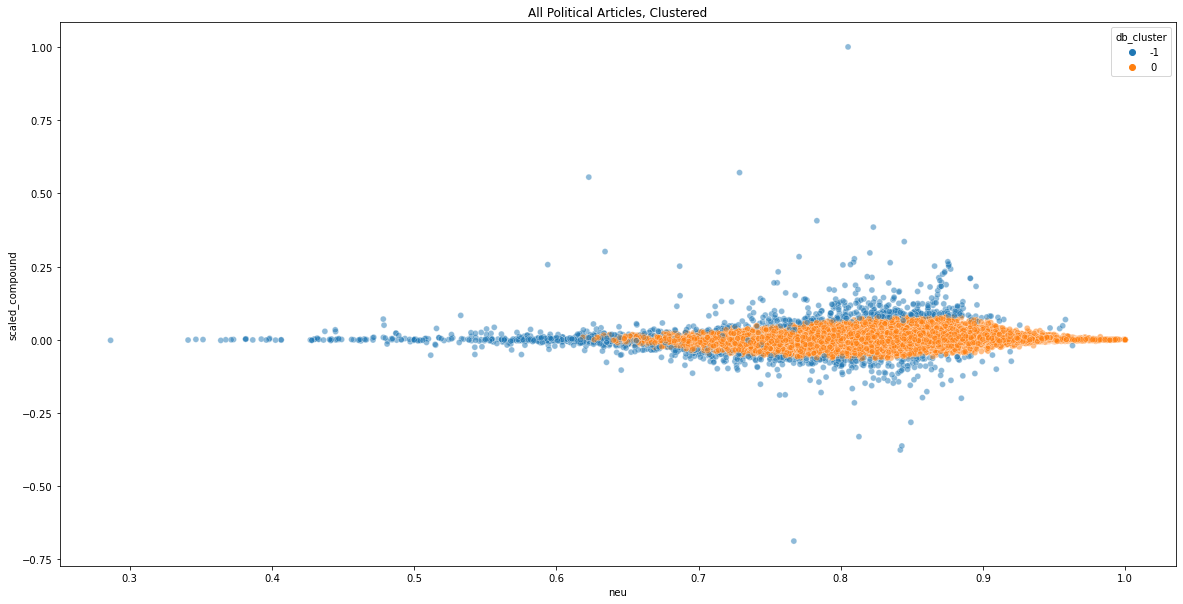

In [412]:
dbscan_all = DBSCAN(eps=0.75, min_samples=100)
db_all_clusters = dbscan_all.fit_predict(all_arts_scaled)
all_arts['db_cluster'] = db_all_clusters
all_arts['db_cluster'] = all_arts['db_cluster'].astype('category')
plt.figure(figsize=(20,10))
sns.scatterplot(x='neu', y='scaled_compound', hue='db_cluster', data=all_arts, alpha=0.5)
plt.title('All Political Articles, Clustered');

The same hyperparameters seem to work well for the group of all political articles. With a lower **eps**, the DBSCAN algorithm finds more than 10 clusters with very few points in each.

In [413]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(all_arts.groupby(['db_cluster', 'publication'])['id'].count())

db_cluster  publication        
-1          Atlantic                 175
            Breitbart                415
            Business Insider         115
            Buzzfeed News             51
            CNN                      108
            Fox News                  27
            Guardian                  54
            NPR                      128
            National Review          122
            New York Post             89
            New York Times            43
            Reuters                   43
            Talking Points Memo      189
            Vox                      117
            Washington Post          157
 0          Atlantic                3465
            Breitbart              13789
            Business Insider        2352
            Buzzfeed News           1806
            CNN                     4817
            Fox News                2400
            Guardian                3222
            NPR                     3731
            National Revi

In [422]:
total_pct = all_arts.groupby('publication')['id'].count() / all_arts.shape[0]
clust_neg1 = pd.DataFrame({'count':all_arts.groupby(['db_cluster', 'publication'])['id'].count()[-1], 'total_pct':total_pct})
clust_neg1['cluster_pct'] = clust_neg1['count'] / clust_neg1['count'].sum()
clust_neg1['diff'] = clust_neg1['cluster_pct'] - clust_neg1['total_pct']
clust_neg1

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,175,0.053788,0.095472,0.041684
Breitbart,415,0.209892,0.226405,0.016513
Business Insider,115,0.036455,0.062739,0.026284
Buzzfeed News,51,0.027441,0.027823,0.000382
CNN,108,0.072776,0.058920,-0.013857
Fox News,27,0.035864,0.014730,-0.021134
Guardian,54,0.048409,0.029460,-0.018949
NPR,128,0.057024,0.069831,0.012807
National Review,122,0.067723,0.066558,-0.001165


This is the noise cluster for all political articles. Publications that are over-represented here have more articles that are outside the realm of "normal" sentiment; those that are under-represented have fewer sentimental outliers.

* OVER-represented:
    * Atlantic
    * Breitbart
    * Business Insider
    * NPR
    * Talking Points Memo
    * Vox
* UNDER-represented:
    * CNN
    * Fox News
    * Guardian
    * New York Times
    * Reuters
    * Washington Post

In [423]:
clust_0 = pd.DataFrame({'count':all_arts.groupby(['db_cluster', 'publication'])['id'].count()[0], 'total_pct':total_pct})
clust_0['cluster_pct'] = clust_0['count'] / clust_0['count'].sum()
clust_0['diff'] = clust_0['cluster_pct'] - clust_0['total_pct']
clust_0

,count,total_pct,cluster_pct,diff
publication,,,,
Atlantic,3465,0.053788,0.052628,-0.001160
Breitbart,13789,0.209892,0.209432,-0.000460
Business Insider,2352,0.036455,0.035723,-0.000732
Buzzfeed News,1806,0.027441,0.027430,-0.000011
CNN,4817,0.072776,0.073162,0.000386
Fox News,2400,0.035864,0.036452,0.000588
Guardian,3222,0.048409,0.048937,0.000528
NPR,3731,0.057024,0.056668,-0.000357
National Review,4461,0.067723,0.067755,0.000032


This cluster contains articles with sentiment scores in the "normal" range for our data. Publications that are over-represented here have more articles that are normally sentiment; those that are under-represented have fewer articles within the sentimental norm.

There are no publications that are disproportionately represented here.

#### All Articles, by Party

In [424]:
party_counts = all_arts.groupby('party')['id'].count()
total_pct = party_counts / all_arts.shape[0]
party_clust_counts = all_arts.groupby(['db_cluster', 'party'])['id'].count()
party_clust_counts

db_cluster  party
-1          dem        676
            rep       1157
 0          dem      24308
            rep      41532
Name: id, dtype: int64

In [425]:
clust_neg1 = pd.DataFrame({'count':party_clust_counts[-1], 'total_pct':total_pct})
clust_neg1['cluster_pct'] = clust_neg1['count'] / clust_neg1['count'].sum()
clust_neg1['diff'] = clust_neg1['cluster_pct'] - clust_neg1['total_pct']
clust_neg1

,count,total_pct,cluster_pct,diff
party,,,,
dem,676,0.369187,0.368794,-0.000393
rep,1157,0.630813,0.631206,0.000393


Neither party is disproportionately represented in the noise cluster.

In [426]:
clust0 = pd.DataFrame({'count':party_clust_counts[0], 'total_pct':total_pct})
clust0['cluster_pct'] = clust0['count'] / clust0['count'].sum()
clust0['diff'] = clust0['cluster_pct'] - clust0['total_pct']
clust0

,count,total_pct,cluster_pct,diff
party,,,,
dem,24308,0.369187,0.369198,0.000011
rep,41532,0.630813,0.630802,-0.000011


Neither party is disproportionately represented in the "normal" cluster, either.

## Conclusions from DBSCAN

Atlantic and Talking Points Memo are the publications most likely to have sentiment scores outside the norm. Breitbart often does as well, but not in the case of articles about Democrats.

While no publications are over-represented in the "normal" cluster for any of the topic groups, the "mainstream" media sources (CNN, New York Times, Washington Post) are generally under-represented in the outliers.